In [1]:
#include <iostream>
#include <string>
#include <stdio.h>
#include <time.h>

In [2]:
TFile *file = TFile::Open("ttbar_8TeV.root"); 

In [3]:
TTree *tree = (TTree*) file->Get("mini");
tree->Print()

******************************************************************************
*Tree    :mini      : 4-vectors + variables required for scaling factors     *
*Entries :  1500000 : Total =       567791759 bytes  File  Size =  300057248 *
*        :          : Tree compression factor =   1.89                       *
******************************************************************************
*Br    0 :runNumber : runNumber/I                                            *
*Entries :  1500000 : Total  Size=    6002049 bytes  File Size  =      31136 *
*Baskets :       18 : Basket Size=     790016 bytes  Compression= 192.75     *
*............................................................................*
*Br    1 :eventNumber : eventNumber/I                                        *
*Entries :  1500000 : Total  Size=    6002093 bytes  File Size  =    3819950 *
*Baskets :       18 : Basket Size=     790016 bytes  Compression=   1.57     *
*...................................................

In [4]:
float evtw = -1;
Int_t MC_runNumber = -1;

tree->SetBranchAddress("mcWeight", &evtw);
tree->SetBranchAddress("runNumber", &MC_runNumber);

In [5]:
MC_runNumber

(int) -1


In [6]:
Bool_t e_trig;
Bool_t mu_trig;
Bool_t good_vtx;
UInt_t lep_n;
UInt_t jet_n;
Float_t MET;
Float_t MET_phi;

tree->SetBranchAddress("trigE", &e_trig);
tree->SetBranchAddress("trigM", &mu_trig);
tree->SetBranchAddress("hasGoodVertex", &good_vtx);
tree->SetBranchAddress("lep_n", &lep_n);
tree->SetBranchAddress("jet_n", &jet_n);
tree->SetBranchAddress("met_et", &MET);
tree->SetBranchAddress("met_phi", &MET_phi);

In [7]:
Float_t lep_pt[10];  
Float_t lep_eta[10];  
Float_t lep_phi[10];  
Float_t lep_E[10];  
Int_t lep_type[10];  
Float_t lep_ptcone30[10];
Float_t lep_etcone20[10];

tree->SetBranchAddress("lep_pt", &lep_pt);
tree->SetBranchAddress("lep_eta", &lep_eta);
tree->SetBranchAddress("lep_phi", &lep_phi);
tree->SetBranchAddress("lep_E", &lep_E);
tree->SetBranchAddress("lep_type", &lep_type);
tree->SetBranchAddress("lep_ptcone30", &lep_ptcone30);
tree->SetBranchAddress("lep_etcone20", &lep_etcone20);

In [8]:
Float_t jet_pt[10]; 
Float_t jet_eta[10];
Float_t jet_jvf[10];
Float_t jet_mv1[10];

tree->SetBranchAddress("jet_pt", &jet_pt);
tree->SetBranchAddress("jet_eta", &jet_eta);
tree->SetBranchAddress("jet_jvf", &jet_jvf);
tree->SetBranchAddress("jet_MV1", &jet_mv1);

In [9]:
Float_t scaleFactor_PILEUP;
Float_t scaleFactor_ELE;
Float_t scaleFactor_MUON;
Float_t scaleFactor_BTAG;
Float_t scaleFactor_TRIGGER;
Float_t scaleFactor_JVFSF;
Float_t scaleFactor_ZVERTEX;

tree->SetBranchAddress("scaleFactor_PILEUP", &scaleFactor_PILEUP);
tree->SetBranchAddress("scaleFactor_ELE", &scaleFactor_ELE);
tree->SetBranchAddress("scaleFactor_MUON", &scaleFactor_MUON);
tree->SetBranchAddress("scaleFactor_BTAG", &scaleFactor_BTAG);
tree->SetBranchAddress("scaleFactor_TRIGGER", &scaleFactor_TRIGGER);
tree->SetBranchAddress("scaleFactor_JVFSF", &scaleFactor_JVFSF);
tree->SetBranchAddress("scaleFactor_ZVERTEX", &scaleFactor_ZVERTEX);

In [10]:
TCanvas *canvas = new TCanvas("Canvas","",800,600);

In [11]:
TH1F *cutflow = new TH1F("Cutflow","Cutflow; Cut; Events",10,0,10);

In [12]:
// Leptons
TH1F *hist_lep_pt = new TH1F("Lepton pT","Lepton pT; pT (GeV); Events",10,1000,100000);
TH1F *hist_lep_ptcone30 = new TH1F("Lepton ptcone30","Lepton ptcone30; ptcone30; Events",10,0,1);
TH1F *hist_lep_etcone20 = new TH1F("Lepton etcone20","Lepton etcone20; etcone20; Events",10,-1,1);
TH1F *hist_lep_eta = new TH1F("Lepton eta","Lepton eta; eta (GeV); Events",10,-4,4);

In [13]:
//Jets
TH1F *hist_jets_pt = new TH1F("Jets pT","Jets pT; pT (GeV); Events",10,0,100000);
TH1F *hist_jets_eta = new TH1F("Jets eta","Jets eta; eta (rad); Events",10,-4,4);
TH1F *hist_jets_JVF = new TH1F("Jets JVF","Jets JVF; JVF; Events",25,0,1);
TH1F *hist_jets_MV1 = new TH1F("Jets MV1 output","Jets MV1 output; MV1 output; Events",10,0,1);

In [14]:
// Number of Jets
TH1F *hist_njets = new TH1F("Number of jets","n-jets; Jet multiplicity; Events",10,0,10);
// B-Jets
TH1F *hist_n_bjets = new TH1F("Number b-Jets ","Number of b-Jets MV1 output; Number of b-Jets; Events",20,0,10);
// MET
TH1F *hist_MET = new TH1F("MET ","MET; MET; Events",20,0,200000);
// mT(W)
TH1F *hist_MTW = new TH1F("mT(w) ","mT(W); mT(w); Events",20,0,200000);

In [15]:
float sumw = 49761200.21;
float red_eff = 0.072212854;
float xsec = 137.29749;
float Ldata = 1000.0;
float Lmc = sumw*red_eff/xsec;
Lmc

(float) 26172.4f


In [16]:
int nentries, nbytes, i;
nentries = (Int_t)tree->GetEntries();

/*Float_t scaleFactor = scaleFactor_ELE*scaleFactor_MUON*scaleFactor_TRIGGER*scaleFactor_PILEUP*scaleFactor_ZVERTEX;
//Float_t ectw = scaleFactor*evtw;

Float_t evtwmc = Ldata/Lmc;
Float_t ectw = scaleFactor*evtwmc;*/ 

In [17]:
int cut1 = 0;
int cut2 = 0;
int cut3 = 0;
int cut4 = 0;
int cut5 = 0;
int cut6 = 0;
int cut7 = 0;
int cut8 = 0;

In [18]:
for (i = 0; i < nentries; i++)
{
    nbytes = tree->GetEntry(i);   

    Float_t scaleFactor = scaleFactor_ELE*scaleFactor_MUON*scaleFactor_JVFSF*scaleFactor_TRIGGER*scaleFactor_PILEUP*scaleFactor_ZVERTEX*scaleFactor_BTAG;

    Float_t evtwmc = Ldata/Lmc;
    Float_t ectw = scaleFactor*evtwmc;
    
    //First cut: Good vertex
    if(!good_vtx) continue;
    cut1++;
    cutflow->Fill(1);

    //Second cut: Trigger
    if(!e_trig && !mu_trig) continue;
    cut2++;
    cutflow->Fill(2);
        
    // Preselection of good leptons                                                                                
    int n_mu=0;
    int n_el=0;
    int n_lep=0;
    int good_lep=0;
  
    //Loop over leptons
    for(unsigned int i=0; i<lep_n; i++){
        
        if( lep_pt[i] < 25000.) continue; 
        if( lep_ptcone30[i]/lep_pt[i] > 0.15 ) continue; 
        if( lep_etcone20[i]/lep_pt[i] > 0.15 ) continue;  
        if( lep_type [i]==13 && TMath::Abs(lep_eta[i]) < 2.5 ){
            n_mu++;
            good_lep=i;}
        if( lep_type [i]==11 && TMath::Abs(lep_eta[i]) < 2.47) { 
            if(TMath::Abs(lep_eta[i]) < 1.37 || TMath::Abs(lep_eta[i]) > 1.52 ){
                n_el++;
                good_lep=i;}}
        
    }
    n_lep = n_mu + n_el;
    
      //Select events with only 1 good lepton and fill the cutflow histogram 
    
    //Third cut (one good lepton):
    if(n_lep!=1) continue;
    cutflow->Fill(3); 
    cut3++;
  
    
    int n_jets=0;
    int n_bjets=0;
    
    if(jet_n<4) continue;
    cutflow->Fill(4);
    cut4++;
    
    for(unsigned int j=0; j<jet_n; j++){
        if(jet_pt[j] < 25000.) continue;
        if(TMath::Abs(jet_eta[j]) > 2.5) continue;
        if(jet_pt[j] < 50000 && TMath::Abs(jet_eta[j])<2.4 && jet_jvf[j]<0.5)continue;
        n_jets++;
        if(TMath::Abs(jet_mv1[j]) < 0.7892) continue;
        n_bjets++;
        
    }
    
    if(n_jets<4) continue; 
    cutflow->Fill(5); 
    cut5++;
    
    
    if(n_bjets<2) continue;
    cutflow->Fill(6);
    cut6++;
    
    
    if(MET<30000.) continue;
    cutflow->Fill(7);
    cut7++;
    
    
    // TLorentzVector definitions                                                               
    TLorentzVector Lepton  = TLorentzVector();
    TLorentzVector  MeT  = TLorentzVector();
    
    //To complete: Lorentz vectors for the lepton and MET. Use SetPtEtaPhiE().
    Lepton.SetPtEtaPhiE(lep_pt[good_lep],lep_eta[good_lep],lep_phi[good_lep],lep_E[good_lep]);
    MeT.SetPtEtaPhiE(MET,0,MET_phi,MET);
    //Calculation of the mTW using TLorentz vectors    
    float mTW = sqrt(2*Lepton.Pt()*MeT.Et()*(1-cos(Lepton.DeltaPhi(MeT))));
    
    if(mTW>30000){
        cutflow->Fill(8);
        cut8++;
        hist_MTW->Fill(mTW/1,ectw);
        hist_MET->Fill(MET/1,ectw);
        hist_njets->Fill(n_jets,ectw);
        hist_n_bjets->Fill(n_bjets,ectw);
        // Hacer loops sobre los jets y los leptones
        for(unsigned int i=0; i<lep_n; i++){
            hist_lep_pt->Fill(lep_pt[i]/1,ectw);
            hist_lep_ptcone30->Fill(lep_ptcone30[i]/(1*lep_pt[i]),ectw);
            hist_lep_etcone20->Fill(lep_etcone20[i]/(1*lep_pt[i]),ectw);
            hist_lep_eta->Fill(lep_eta[i],ectw); 
        }
        for(unsigned int j=0; j<jet_n; j++){
            hist_jets_pt->Fill(jet_pt[j]/1,ectw);
            hist_jets_eta->Fill(jet_eta[j],ectw);
            hist_jets_JVF->Fill(jet_jvf[j],ectw);
            hist_jets_MV1->Fill(jet_mv1[j]/1,ectw);
            
        }
    }
    
}
std::cout << "Done!" << std::endl;
std::cout << "All events:" << nentries << std::endl;
std::cout << "Cut1:" << cut1 << std::endl;
std::cout << "Cut2:" << cut2 << std::endl;
std::cout << "Cut3:" << cut3 << std::endl;
std::cout << "Cut4:" << cut4 << std::endl;
std::cout << "Cut5:" << cut5 << std::endl;
std::cout << "Cut6:" << cut6 << std::endl;
std::cout << "Cut7:" << cut7 << std::endl;
std::cout << "Cut8:" << cut8 << std::endl;

Done!
All events:1500000
Cut1:1499487
Cut2:1499487
Cut3:1336214
Cut4:623273
Cut5:622125
Cut6:259904
Cut7:214514
Cut8:180967


In [ ]:
/*
float factor = sumw*red_eff;

hist_njets->Scale(factor);
hist_lep_pt->Scale(factor);
hist_lep_ptcone30->Scale(factor);
hist_lep_etcone20->Scale(factor);
hist_lep_eta->Scale(factor);
hist_jets_pt->Scale(factor);
hist_jets_eta->Scale(factor);
hist_jets_JVF->Scale(factor);
hist_jets_MV1->Scale(factor);
hist_n_bjets->Scale(factor);
hist_MET->Scale(factor);
hist_MTW->Scale(factor);*/

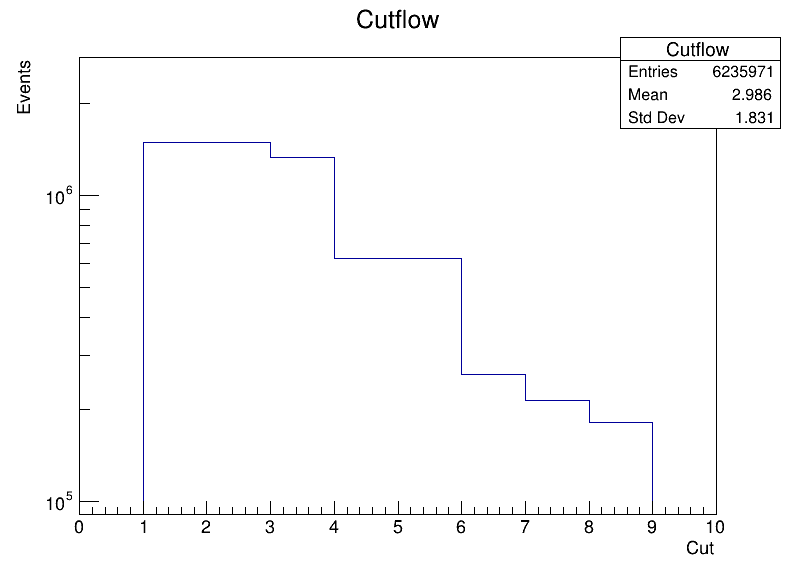

In [19]:
cutflow->Draw("");
canvas->SetLogy();
canvas->Draw();

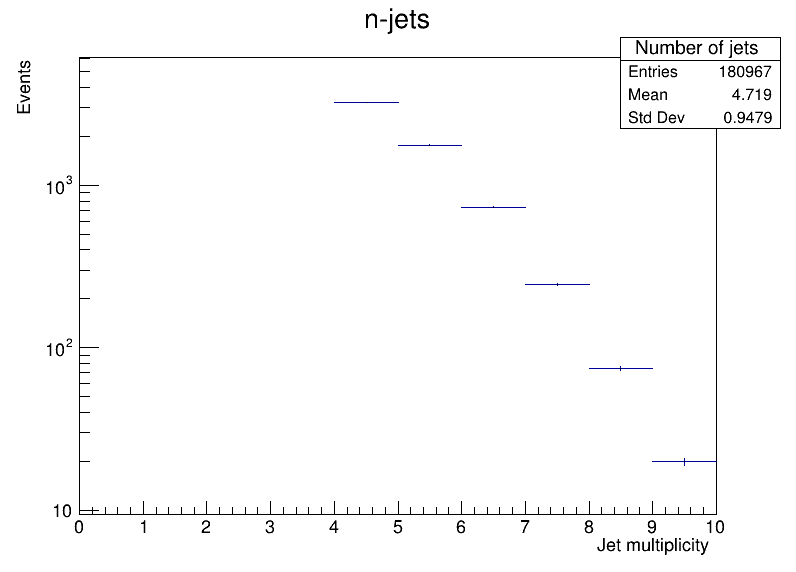

In [20]:
hist_njets->Draw();
canvas->SetLogy();
canvas->Draw();

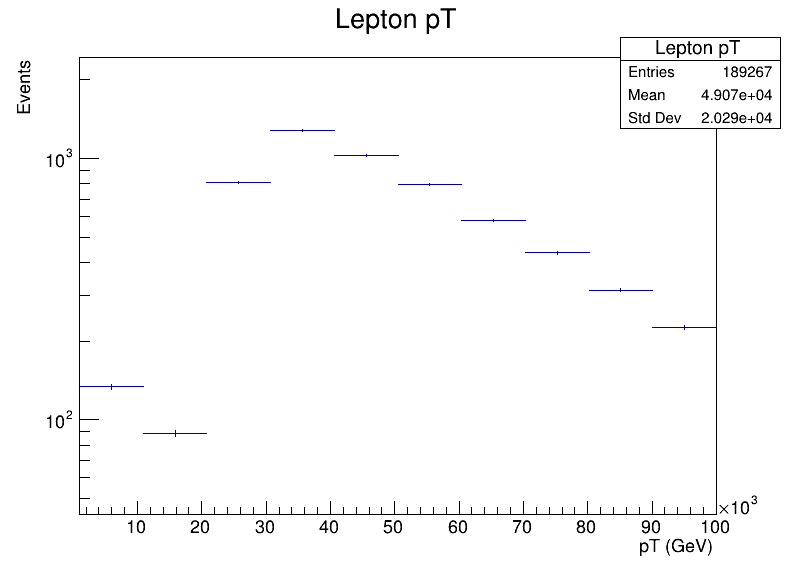

In [21]:

hist_lep_pt->Draw();
canvas->SetLogy();
canvas->Draw();

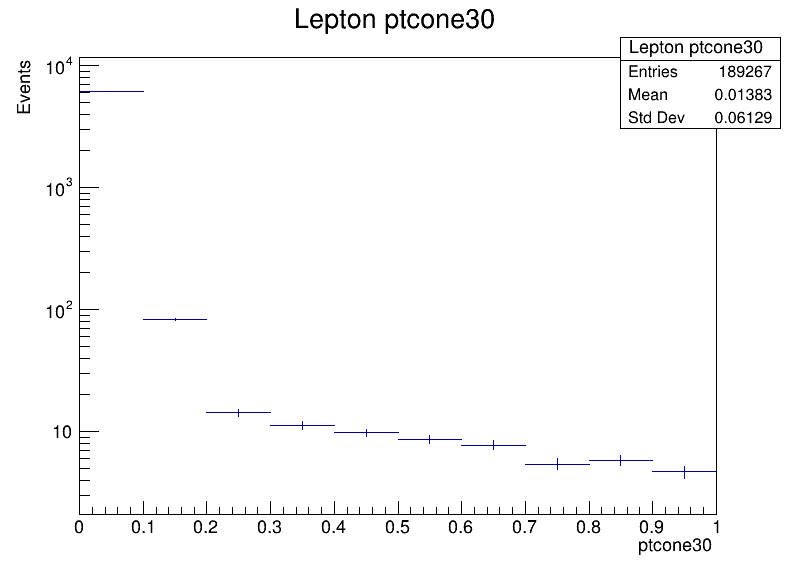

In [22]:

hist_lep_ptcone30->Draw();
canvas->SetLogy();
canvas->Draw();

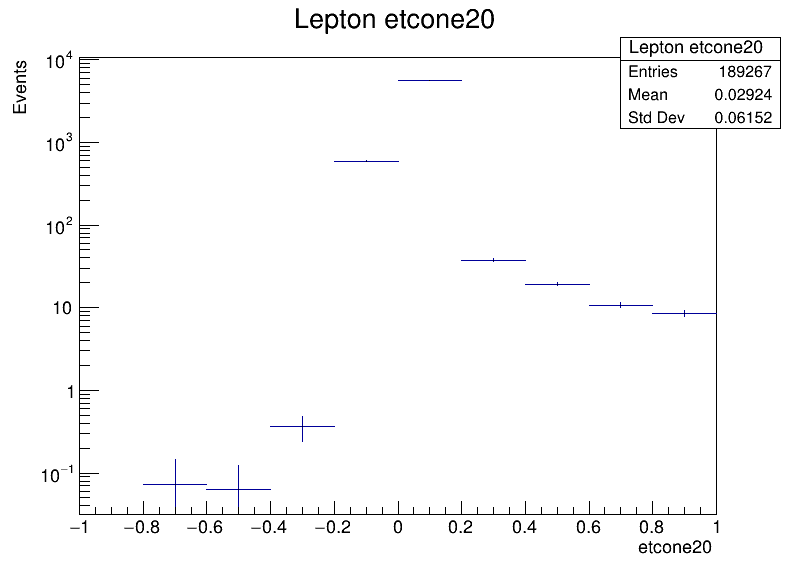

In [23]:

hist_lep_etcone20->Draw();
canvas->SetLogy();
canvas->Draw();

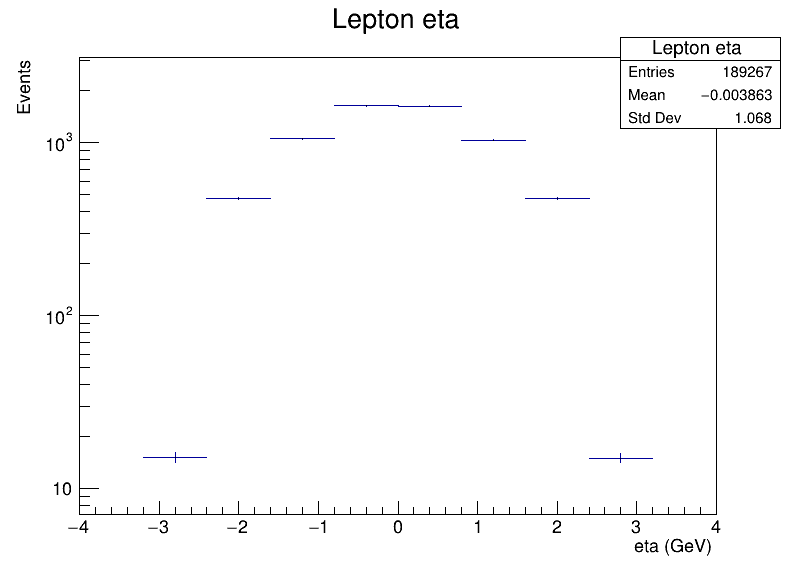

In [24]:

hist_lep_eta->Draw();
canvas->Draw();

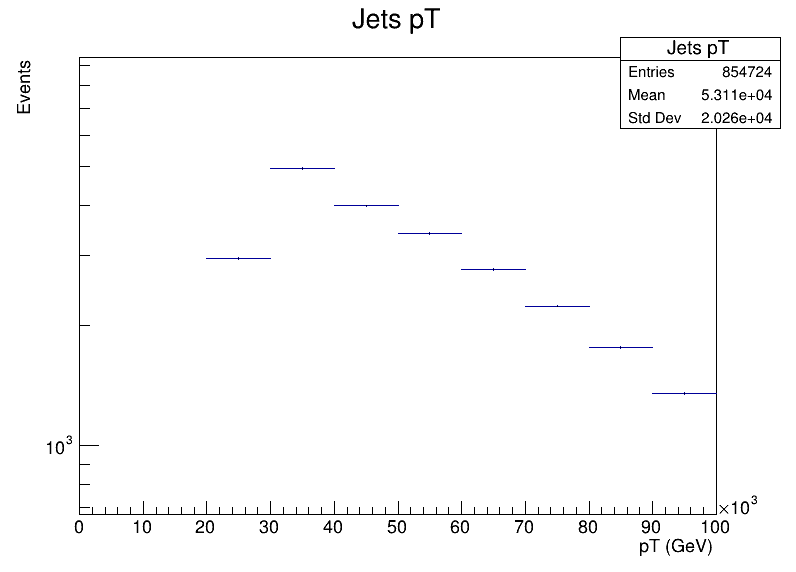

In [25]:

hist_jets_pt->Draw();
canvas->SetLogy();
canvas->Draw();

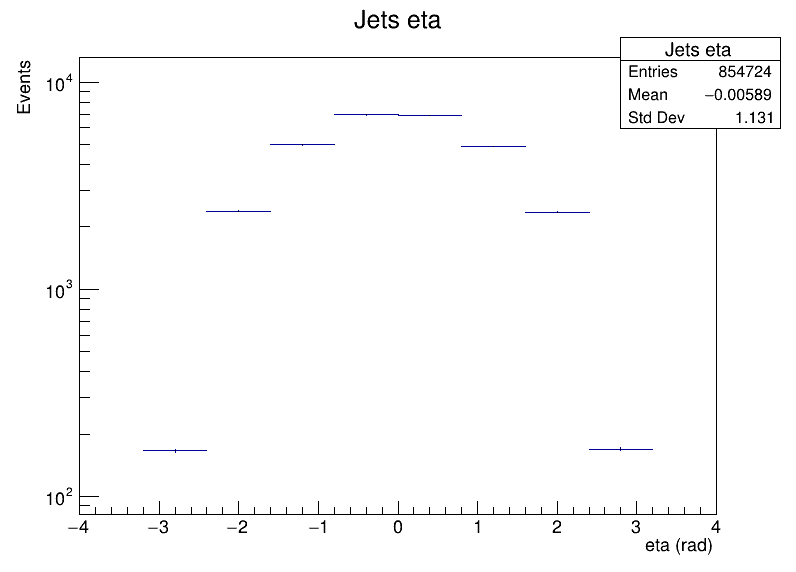

In [26]:

hist_jets_eta->Draw();
canvas->Draw();

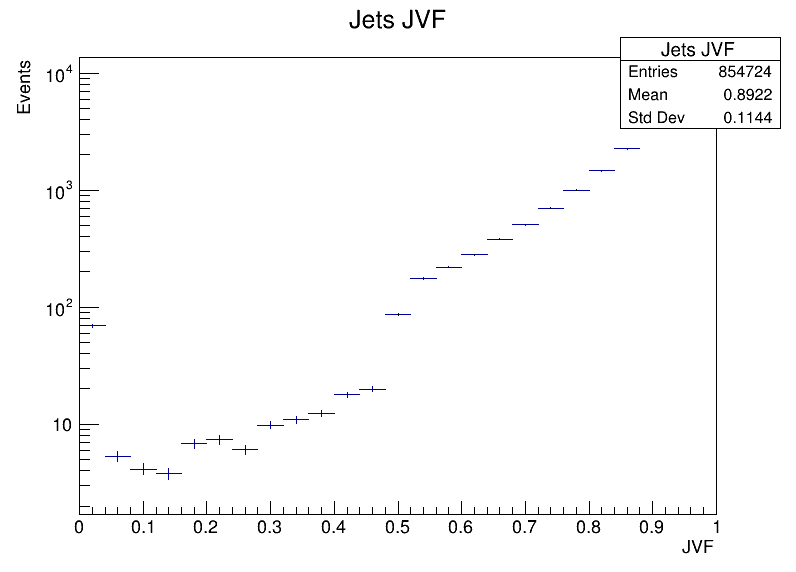

In [27]:

hist_jets_JVF->Draw();
canvas->Draw();

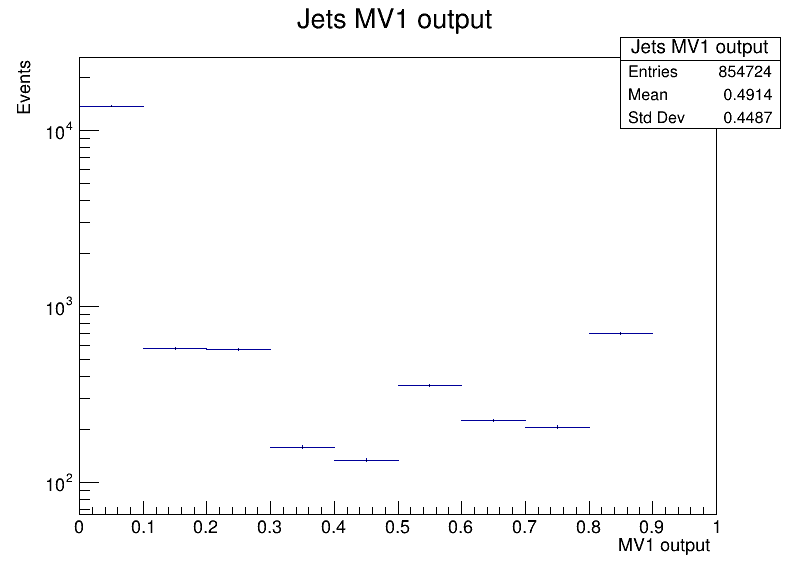

In [28]:

hist_jets_MV1->Draw();
canvas->Draw();

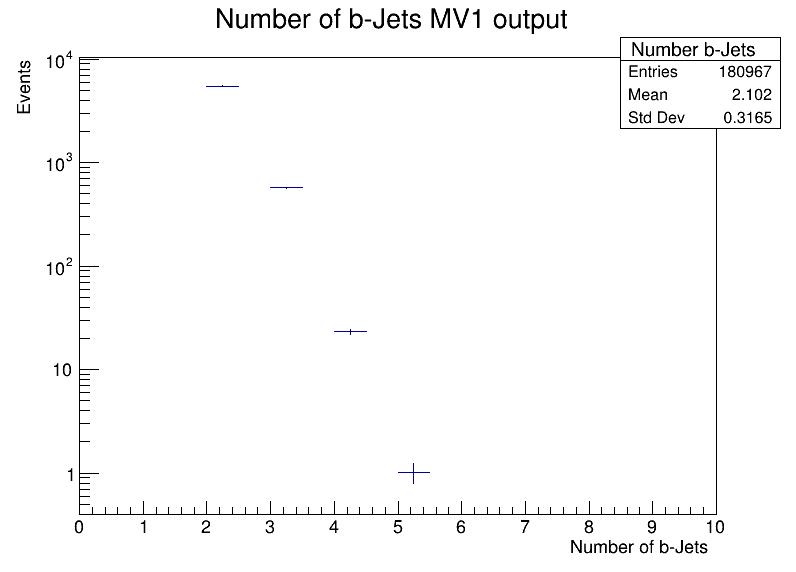

In [29]:
hist_n_bjets->Draw();
canvas->Draw();

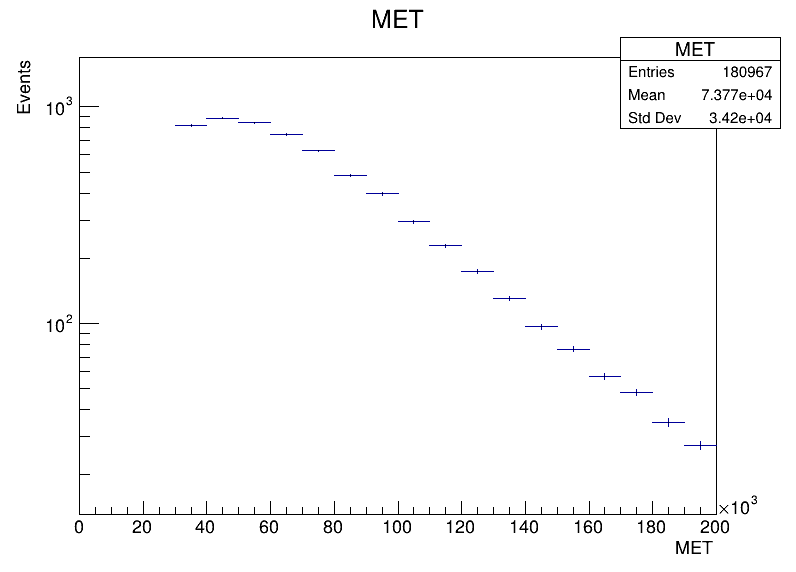

In [30]:

hist_MET->Draw();
canvas->Draw();

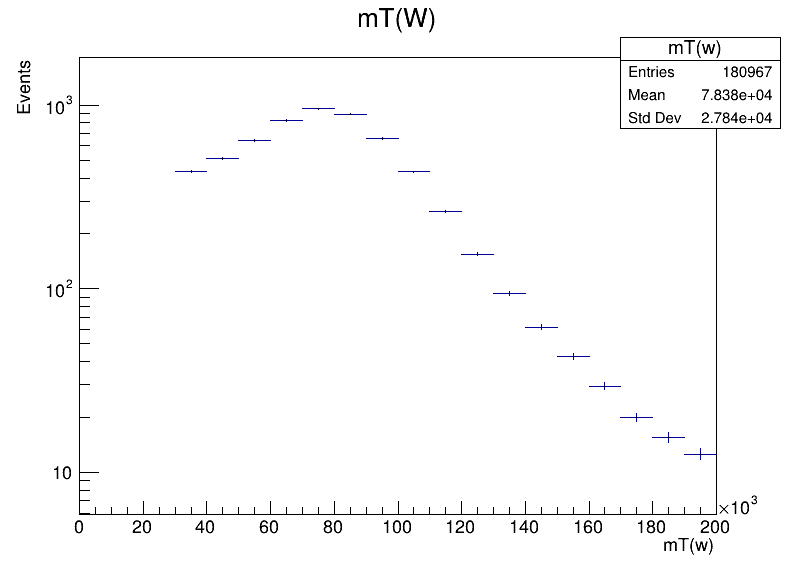

In [31]:

hist_MTW->Draw();
canvas->Draw();